# Calculate the barotropic stream function on the ORCA grid

## Preamble: Import modules, turn off warnings, etc.

In [1]:
# make sure we find xorca
import sys
sys.path.append("..")

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
from dask.distributed import Client
from pathlib import Path
import xarray as xr

In [4]:
from xorca.lib import preprocess_orca
from xorca.calc import calculate_psi

## Connect to cluster

If there is a scheduler, we'll connect to it.  Otherwise, everything will be done with the normal dask backend.  (Which still is automatically shared-memory parallelizing calculations.)

Click on the **"Dashboard"** link to see the Dashboard for the cluster.

In [5]:
try:
    assert Path("scheduler.json").exists()
    client = Client(scheduler_file="scheduler.json")
    client
except:
    print("Did not find a cluster.  Will continue without.")

## Get the mesh-mask file and the basin masks and generate grid info

In [6]:
data_path = Path("../example-data/ORCA05.L46-KKG36F25H/")

## Add  zonal and meridional velocity to grid-aware data set

(To create one data set for a whole model run, this would be done in a similar fashion for all other variables from the `{grid_{T,U,V,W},icemod}` files.)

In [7]:
ds = xr.open_mfdataset(
    sorted(data_path.glob("ORCA05.L46-KKG36F25H_1m_20090101_20091231_grid_[U,V].nc")) +
    [data_path / "mesh_mask.nc", ],
    preprocess=(lambda ds: preprocess_orca(data_path / "mesh_mask.nc", ds)))
ds

<xarray.Dataset>
Dimensions:        (t: 12, x_c: 720, x_r: 720, y_c: 509, y_r: 509, z_c: 46, z_l: 46)
Coordinates:
  * x_c            (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    llat_rr        (y_r, x_r) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
  * z_l            (z_l) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 ...
    llat_cc        (y_c, x_c) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    depth_l        (z_l) float64 dask.array<shape=(46,), chunksize=(46,)>
  * z_c            (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x_r            (x_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
  * y_r            (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
    llat_rc        (y_r, x_c) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    llon_rr        (y_r, x_r) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
  * y_c            (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 1

## Calculate barotropic transport and barotropic stream function

(Note the tiny memory use in the actual calculation of `psi_mean` below!  This is because the actual work is not done in the Python process running the kernel for this notebook but on the cluster.)

In [8]:
calculate_psi??

Signature: calculate_psi(ds)
Source:   
def calculate_psi(ds):
    grid = xgcm.Grid(ds, periodic=["Y", "X"])
    U_bt = (ds.vozocrtx * ds.e3u).sum("z_c")
    psi = grid.cumsum(- U_bt * ds.e2u, "Y") / 1.0e6
    psi -= psi.isel(y_r=-1, x_r=-1)  # normalize upper right corner
    psi = psi.rename("psi")
    return psi
File:      ~/work/xorca/xorca/calc.py
Type:      function


In [9]:
psi = calculate_psi(ds)
psi

<xarray.DataArray 'psi' (t: 12, y_r: 509, x_r: 720)>
dask.array<shape=(12, 509, 720), dtype=float64, chunksize=(12, 509, 720)>
Coordinates:
  * t        (t) datetime64[ns] 2009-01-16T12:00:00 2009-02-15 ...
  * y_r      (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * x_r      (x_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...

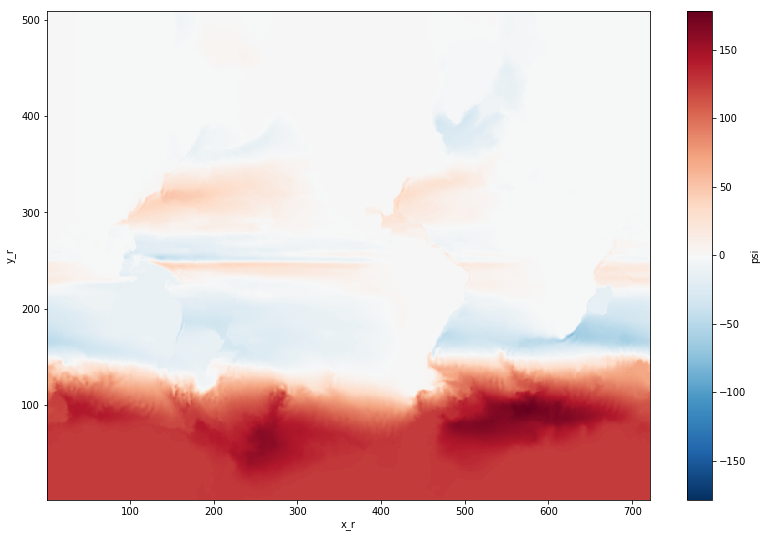

In [10]:
psi.mean("t").plot(size=9);